# Expected Completion
Attempting to predict completion percentage.

## Libraries

In [1]:
import logging
import sys
import warnings

import numpy as np
import pandas as pd
from pandas_gbq import read_gbq

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    log_loss
)

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from xgboost import (
    XGBClassifier,
    plot_importance
)

from pygam import (
    GAM,
    LogisticGAM,
    s,
    f,
    te
)

from yellowbrick.classifier import (
    ClassPredictionError,
    ClassificationReport,
    ROCAUC,
    PrecisionRecallCurve,
    DiscriminationThreshold
)

## Setup

In [2]:
# Supress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# BQ Logging
logger = logging.getLogger('pandas_gbq')
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [4]:
# Pandas display
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
# Seaborn
sns.set(rc={'figure.figsize': (16, 9)})

In [6]:
# BigQuery
PROJECT_ID = 'ad-big-data-bowl'
SERVICE_ACCOUNT_PATH = '../credentials/bigquery-admin.json'

In [7]:
SQL_BASE = \
"""
SELECT
  *,
  COS(qb_pass_direction - throw_direction) * qb_pass_speed AS qb_pass_velo_par,
  SIN(qb_pass_direction - throw_direction) * qb_pass_speed AS qb_pass_velo_orth
FROM
  (
    SELECT
      game_id,
      play_id,
      MAX(CASE WHEN position = 'QB' THEN nfl_id END) AS qb_nfl_id,
      MAX(CASE WHEN position = 'QB' THEN display_name END) AS qb_name,
      MAX(CASE WHEN targeted_receiver_flag = 1 THEN nfl_id END) AS receiver_nfl_id,
      MAX(CASE WHEN targeted_receiver_flag = 1 THEN display_name END) AS receiver_name,
      MAX(pass_complete_flag) AS pass_complete_flag,
      MAX(play_epa) AS play_epa,
      MAX(play_air_epa) AS play_air_epa,
      MAX(play_yac_epa) AS play_yac_epa,
      MAX(play_comp_air_epa) AS play_comp_air_epa,
      MAX(play_comp_yac_epa) AS play_comp_yac_epa,
      MAX(time_to_pass) AS time_to_pass,
      MAX(CASE WHEN position = 'QB' THEN pass_speed END) AS qb_pass_speed,
      MAX(CASE WHEN position = 'QB' THEN pass_direction END) AS qb_pass_direction,
      MAX(throw_direction) AS throw_direction,
      MAX(throw_distance) AS throw_distance,
      MAX(arrived_endline_distance) AS arrived_endline_distance,
      MAX(arrived_sideline_distance) AS arrived_sideline_distance,
      MAX(FLOOR(arrived_ball_x_rel)) AS arrived_x_rel,
      MAX(FLOOR(arrived_ball_y)) AS arrived_y,
      MIN(CASE WHEN player_side = 'defense' THEN pass_ball_distance END) AS closest_pass_rusher_distance,
      MIN(CASE WHEN player_side = 'defense' THEN arrived_ball_distance END) AS closest_pass_defender_distance,
      MIN(CASE WHEN player_side = 'defense' THEN arrived_pred_ball_distance END) AS closest_pred_pass_defender_distance,
      COALESCE(SUM(CASE WHEN player_side = 'defense' AND pass_ball_distance < 1 THEN 1 END), 0) AS pass_rushers_1yd,
      COALESCE(SUM(CASE WHEN player_side = 'defense' AND pass_ball_distance < 2 THEN 1 END), 0) AS pass_rushers_2yd,
      COALESCE(SUM(CASE WHEN player_side = 'defense' AND pass_ball_distance < 3 THEN 1 END), 0) AS pass_rushers_3yd,
      COALESCE(SUM(CASE WHEN player_side = 'defense' AND arrived_ball_distance < 2 THEN 1 END), 0) AS pass_defenders_2yd,
      COALESCE(SUM(CASE WHEN player_side = 'defense' AND arrived_ball_distance < 4 THEN 1 END), 0) AS pass_defenders_4yd,
      COALESCE(SUM(CASE WHEN player_side = 'defense' AND arrived_ball_distance < 5 THEN 1 END), 0) AS pass_defenders_5yd
    FROM
      (
        SELECT
          *
        FROM
          `ad-big-data-bowl.workspace.passes_enhanced`
        WHERE
          personnel_offense_type = 'conventional'
            AND play_epa IS NOT NULL
      )
    GROUP BY 1, 2
  )
"""

In [8]:
# sql_base = SQL_BASE.format(**PARAMS)
sql_base = SQL_BASE

df_base = pd.read_gbq(query=sql_base,
                      project_id=PROJECT_ID,
                      dialect='standard',
                      private_key=SERVICE_ACCOUNT_PATH)

df_copy = df_base.copy()

  Elapsed 6.26 s. Waiting...
  Elapsed 7.69 s. Waiting...
  Elapsed 8.94 s. Waiting...
  Elapsed 10.35 s. Waiting...
  Elapsed 11.56 s. Waiting...
  Elapsed 12.79 s. Waiting...
  Elapsed 14.25 s. Waiting...
  Elapsed 15.68 s. Waiting...
  Elapsed 16.91 s. Waiting...
  Elapsed 18.35 s. Waiting...
Total time taken 22.34 s.
Finished at 2019-01-19 18:31:18.


In [10]:
df_base.head()

game_id  play_id  qb_nfl_id        qb_name  receiver_nfl_id  \
0  2017091009      264    2495425  Scott Tolzien      2532865.000   
1  2017091005      591    2543640     Tom Savage      2540165.000   
2  2017091009      534    2495425  Scott Tolzien      2530660.000   
3  2017091005      480    2543640     Tom Savage      2533034.000   
4  2017091009     1128    2495425  Scott Tolzien      2530660.000   

     receiver_name  pass_complete_flag  play_epa  play_air_epa  play_yac_epa  \
0      T.Y. Hilton                   0    -6.107         3.040        -9.147   
1  DeAndre Hopkins                   0    -0.934         1.598        -2.532   
2      Kamar Aiken                   0    -2.247         1.776        -4.023   
3     Lamar Miller                   1     0.678         1.919        -1.241   
4      Kamar Aiken                   0    -1.579         3.188        -4.768   

   play_comp_air_epa  play_comp_yac_epa  time_to_pass  qb_pass_speed  \
0              0.000              0.000         2.700          1.320   
1              0.000              0.000         4.500          4.190   
2              0.000              0.000         1.600          1.050   
3              1.919             -1.241         2.600          1.290   
4              0.000              0.000         3.100          0.330   

   qb_pass_direction  throw_direction  throw_distance  \
0            232.640          314.900          30.940   
1            161.100          292.570          25.020   
2            256.700          209.370          16.190   
3            359.750          241.400          11.990   
4            326.940           73.090          30.980   

   arrived_endline_distance  arrived_sideline_distance  arrived_x_rel  \
0                    48.450                      6.190        -14.000   
1                    44.900                     14.690         16.000   
2                     9.310                     12.540          2.000   
3                    77.630                     24.100          4.000   
4                    61.390                     15.690         21.000   

   arrived_y  closest_pass_rusher_distance  closest_pass_defender_distance  \
0     47.000                         1.510                           0.810   
1     38.000                         1.610                           2.740   
2     12.000                         3.810                           0.540   
3     24.000                         0.860                           6.520   
4     37.000                         3.450                           0.820   

   closest_pred_pass_defender_distance  pass_rushers_1yd  pass_rushers_2yd  \
0                                3.720                 0                 1   
1                                8.470                 0                 2   
2                                0.830                 0                 0   
3                                2.660                 1                 2   
4                               10.080                 0                 0   

   pass_rushers_3yd  pass_defenders_2yd  pass_defenders_4yd  \
0                 4                   1                   1   
1                 2                   0                   4   
2                 0                   2                   2   
3                 3                   0                   0   
4                 0                   1                   1   

   pass_defenders_5yd  qb_pass_velo_par  qb_pass_velo_orth  
0                   1             1.105             -0.722  
1                   4             3.723              1.923  
2                   2            -1.028             -0.215  
3                   0             0.664             -1.106  
4                   1            -0.269              0.191

## Data preparation

In [11]:
# Base filters
_under_6s = df_base['time_to_pass'] < 6
_rusher_10y = df_base['closest_pass_rusher_distance'] < 10
_defender_30 = df_base['closest_pred_pass_defender_distance'] < 30
_inbounds_4 = df_base['arrived_sideline_distance'] > -4
_beyond_deep_backfield = df_base['arrived_x_rel'] > -10

df_pred = df_base[_under_6s & _rusher_10y & _defender_30 & _inbounds_4 & _beyond_deep_backfield]

In [12]:
# Pred filters
_complete = df_pred['pass_complete_flag'] == 1
_incomplete = df_pred['pass_complete_flag'] == 0

## Plotting

In [13]:
key_features = [
    'time_to_pass',
    'qb_pass_speed',
    'qb_pass_velo_par',
    'qb_pass_velo_orth',
    'throw_distance',
    'arrived_endline_distance',
    'arrived_sideline_distance',
    'closest_pass_rusher_distance',
    'closest_pass_defender_distance',
    'closest_pred_pass_defender_distance'
]

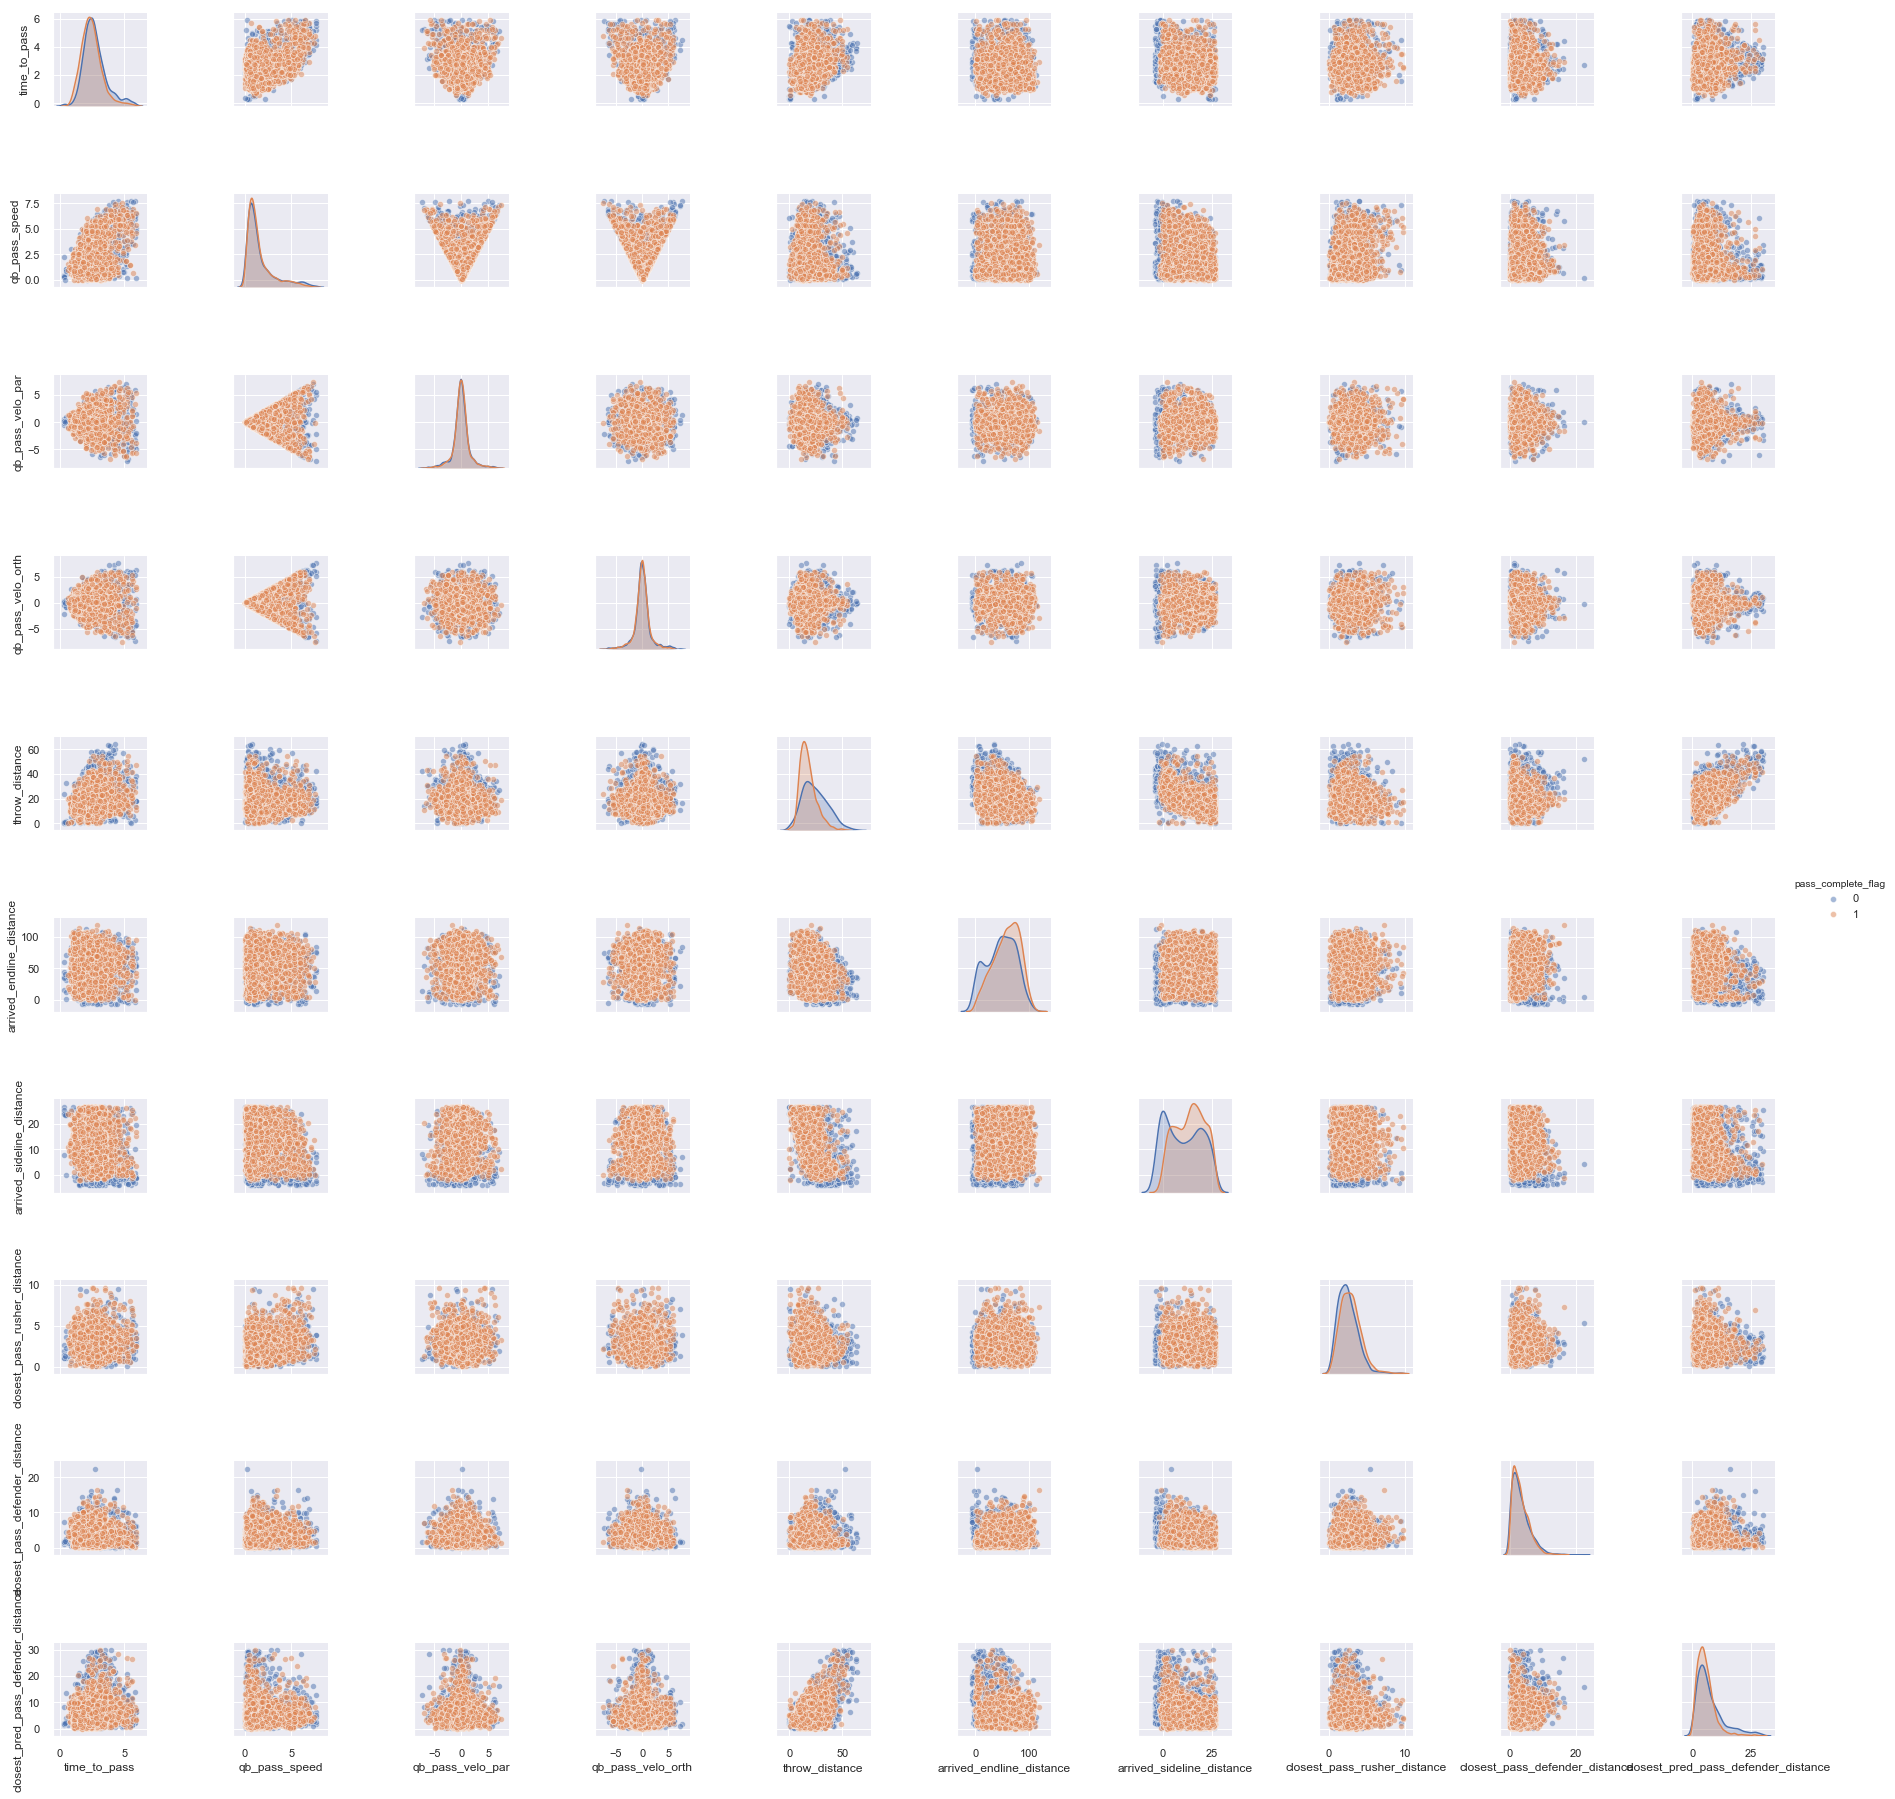

In [14]:
sns.pairplot(data=df_pred,
             vars=key_features,
             hue='pass_complete_flag',
             plot_kws={'alpha': 0.5})

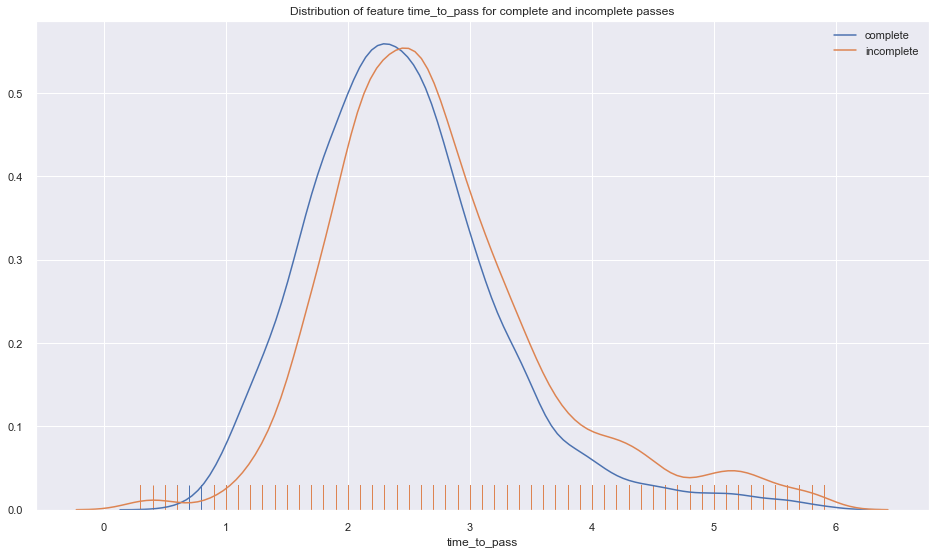

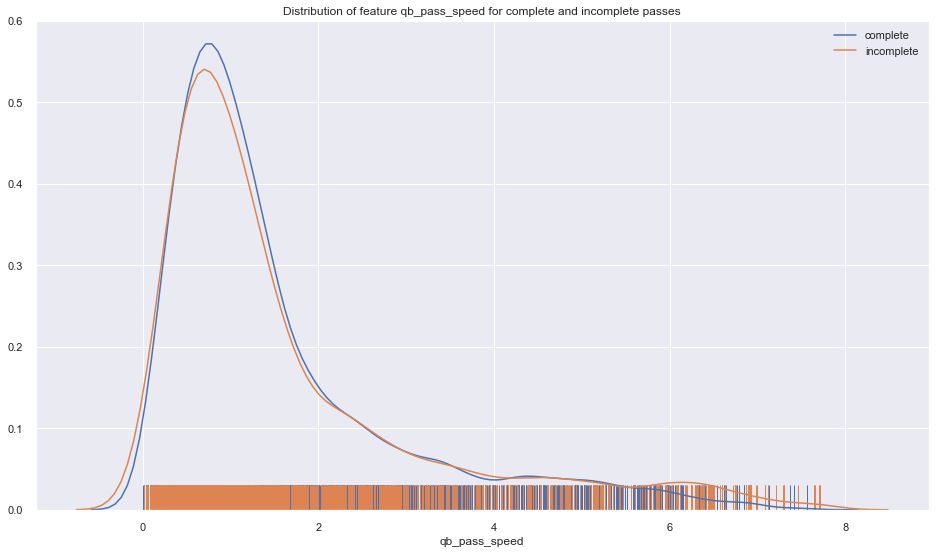

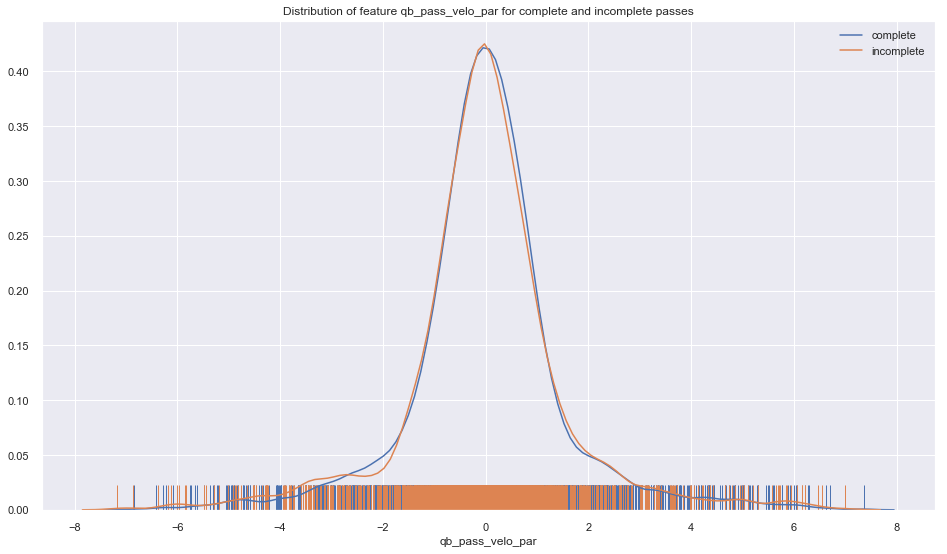

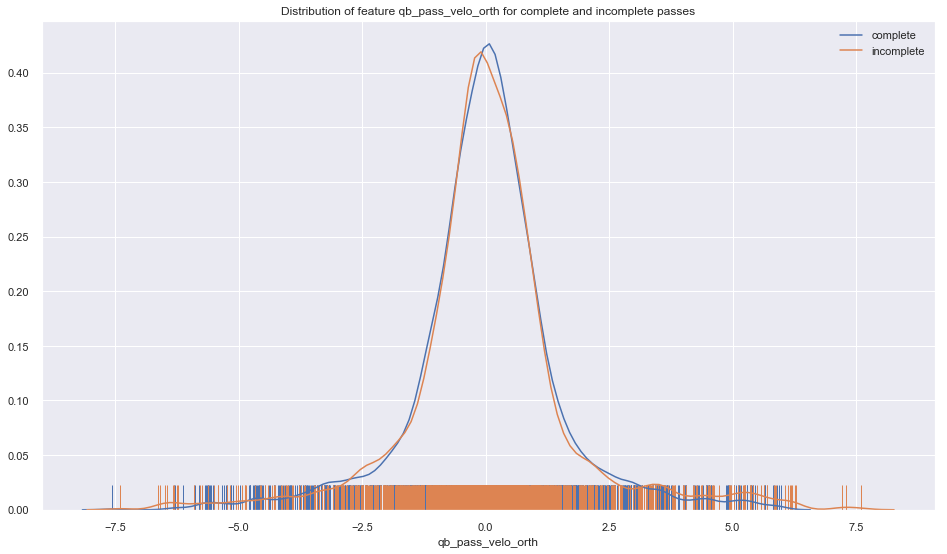

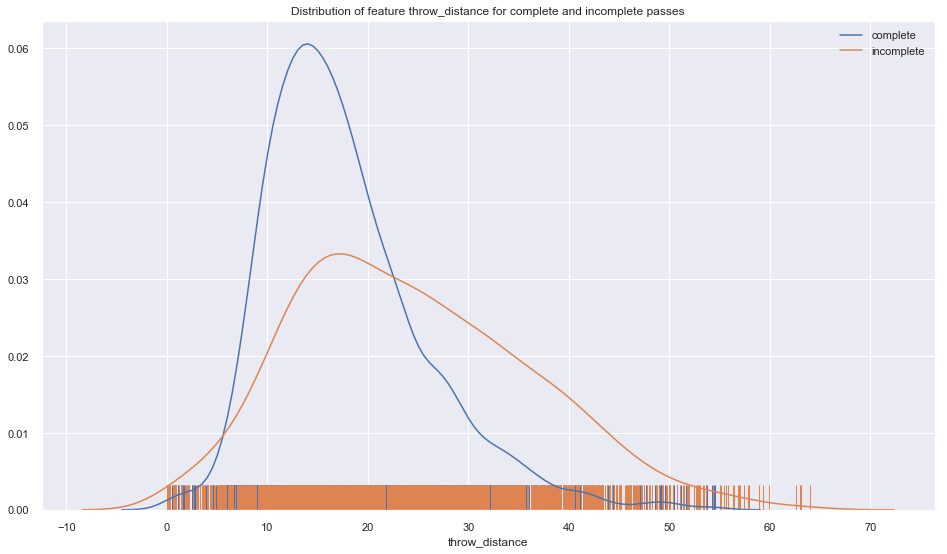

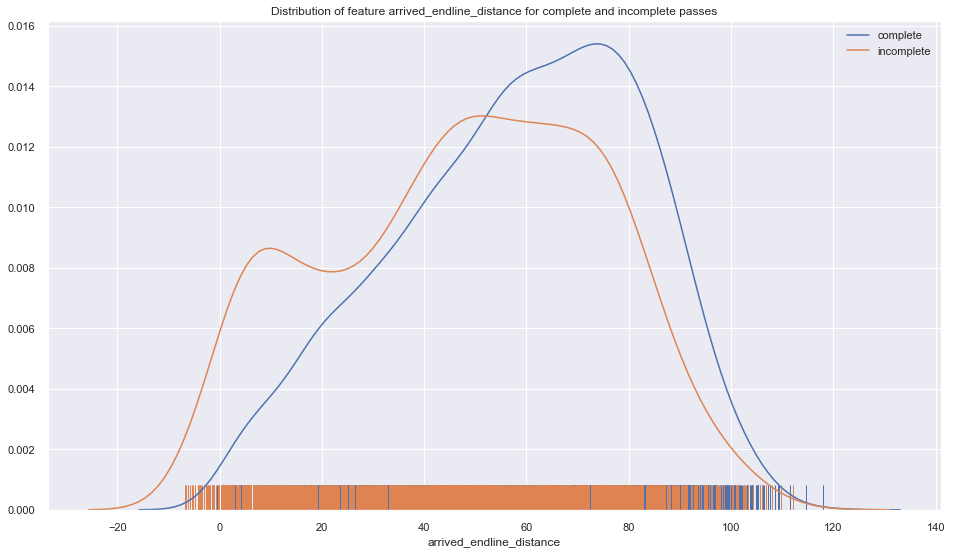

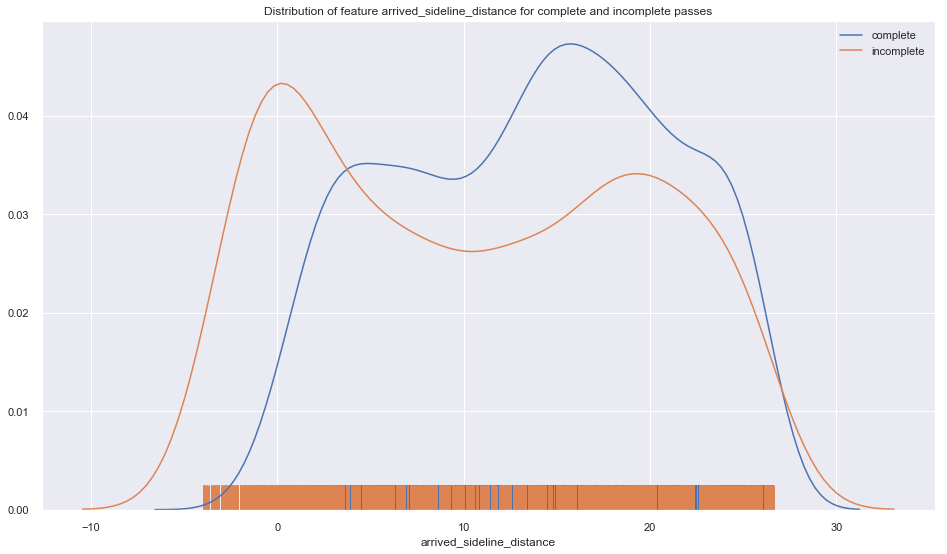

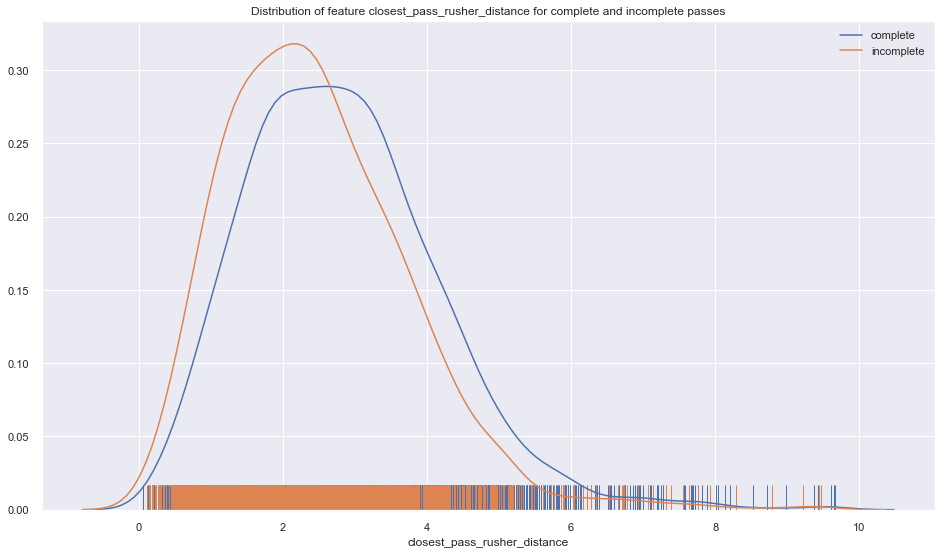

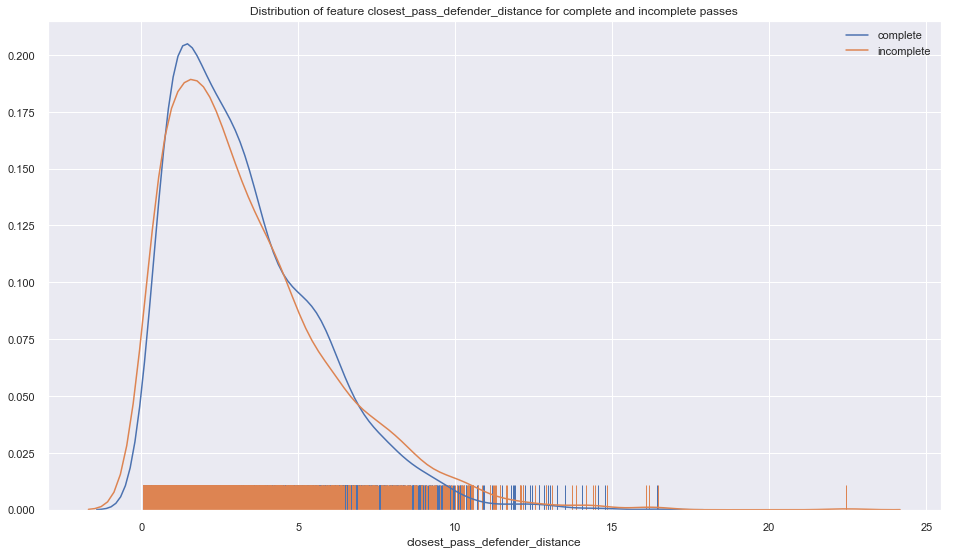

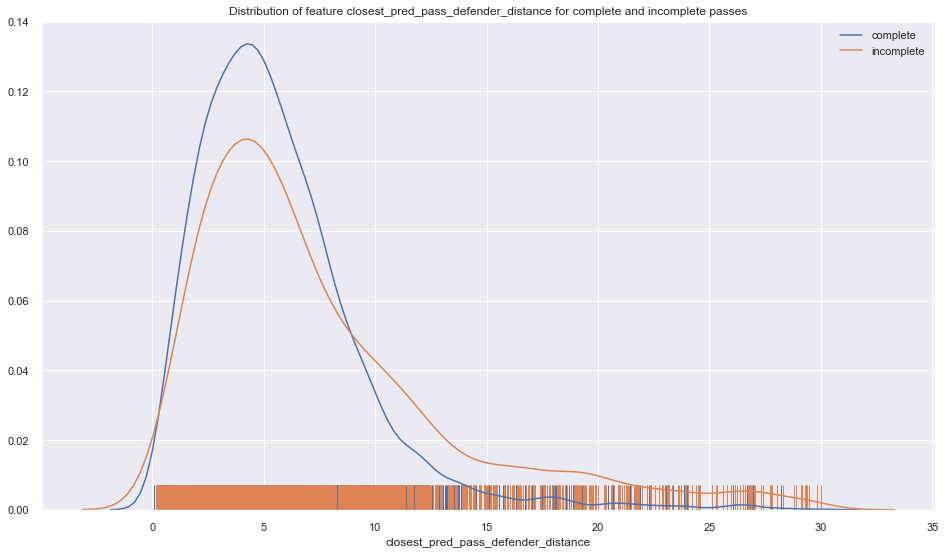

In [15]:
for feature in key_features:
    _comp_data = df_pred[_complete][feature]
    _inc_data = df_pred[_incomplete][feature]
    
    sns.distplot(a=_comp_data, label='complete', hist=False, rug=True)
    sns.distplot(a=_inc_data, label='incomplete', hist=False, rug=True)

    plt.title('Distribution of feature {:s} for complete and incomplete passes'.format(feature))
    plt.show()

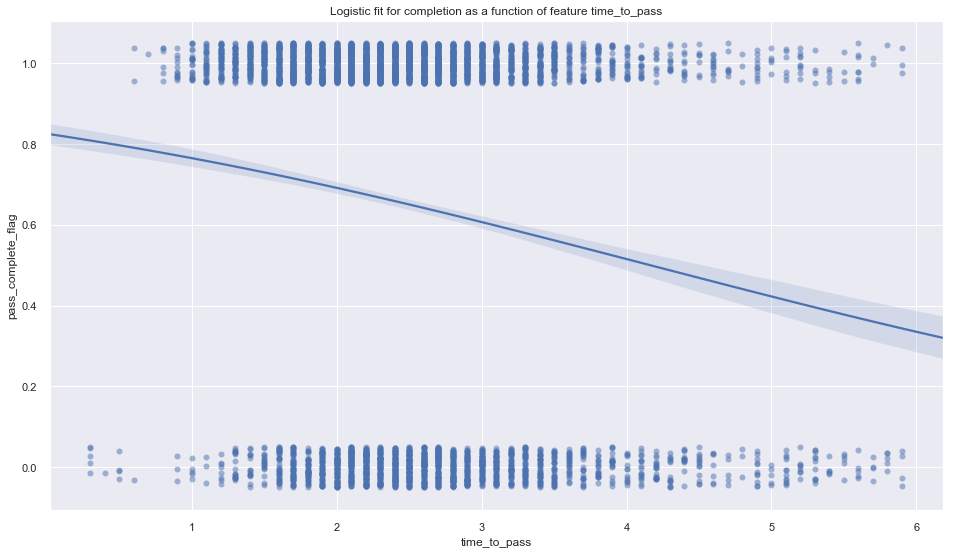

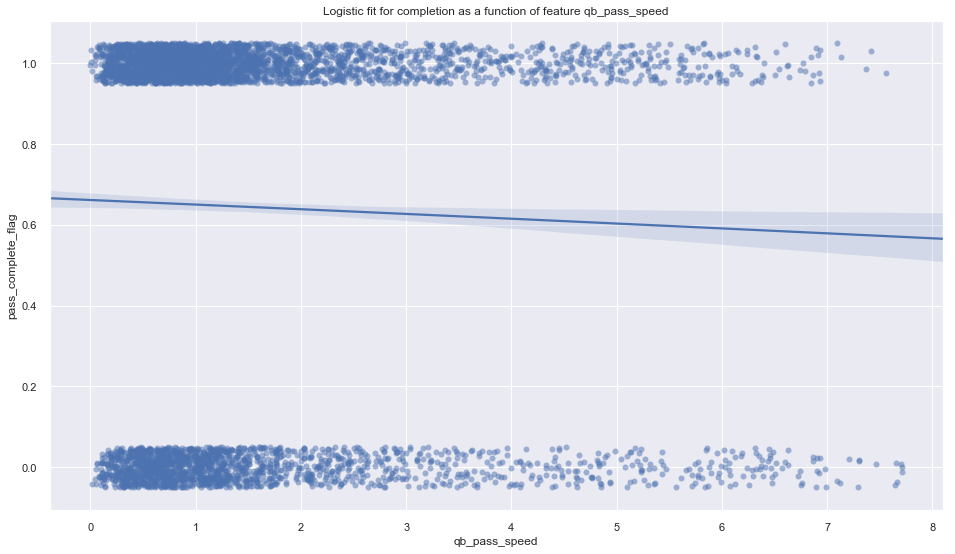

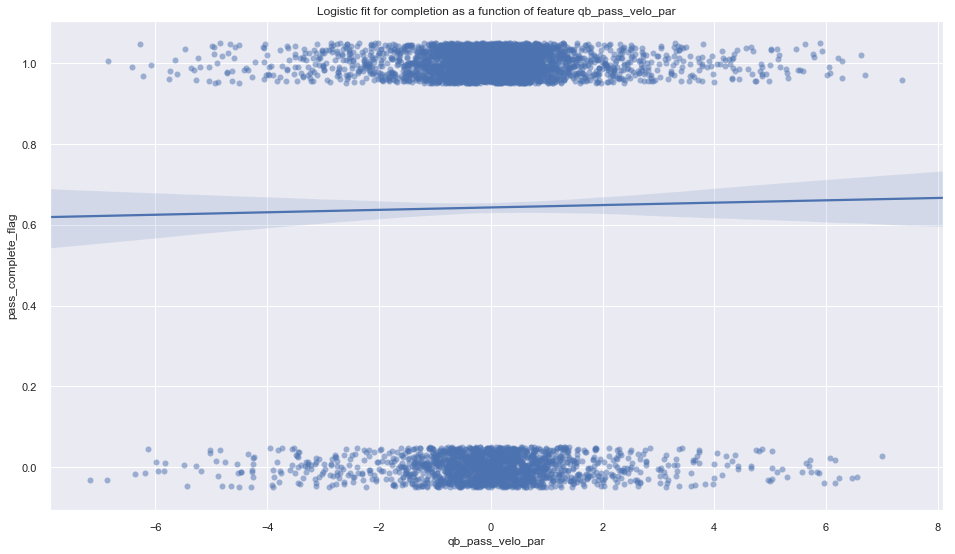

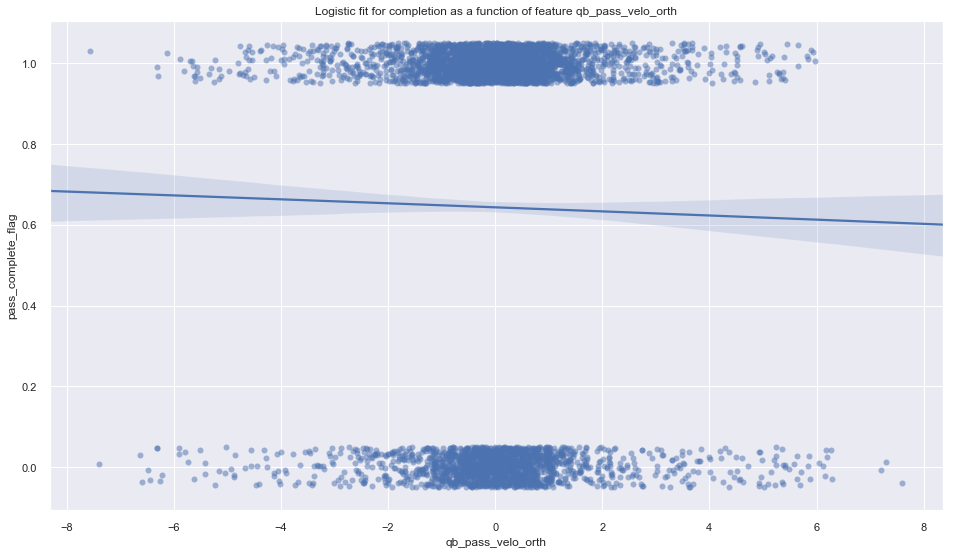

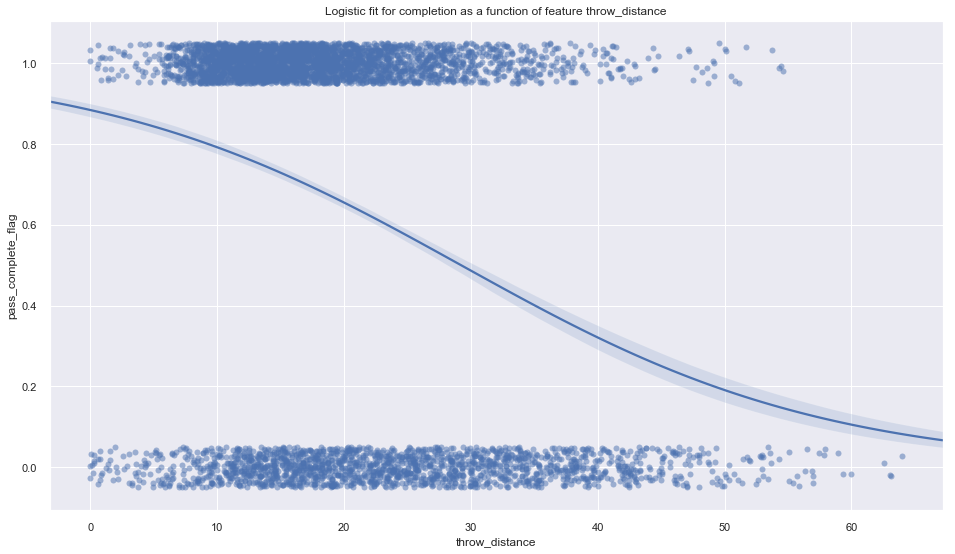

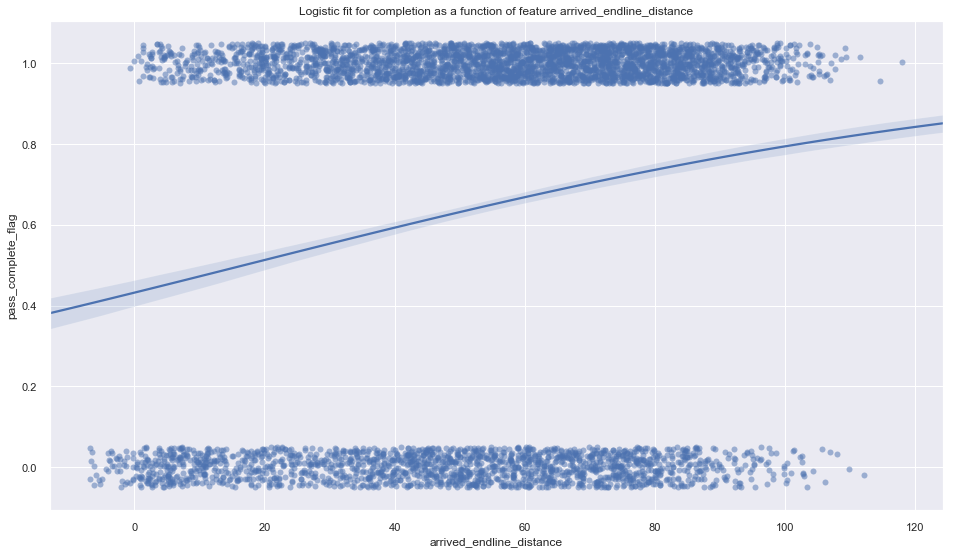

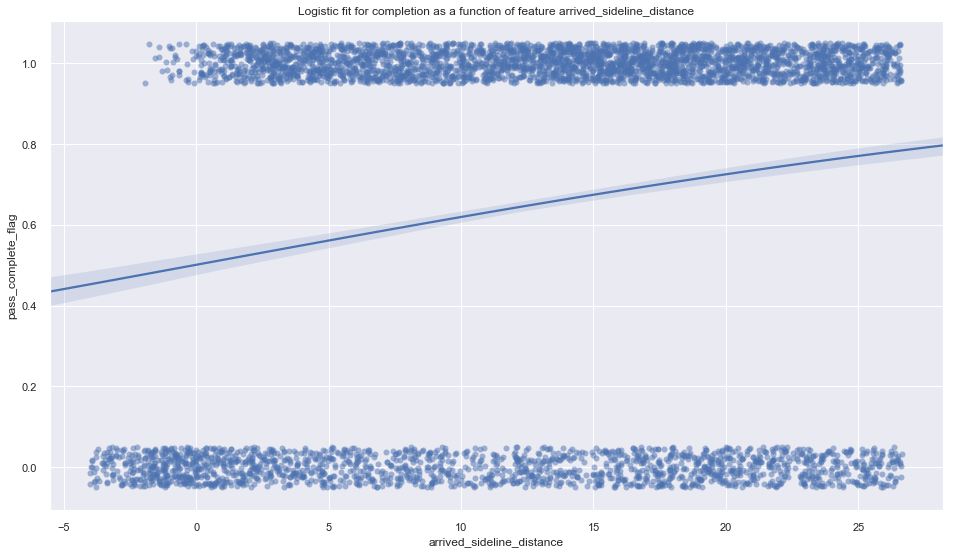

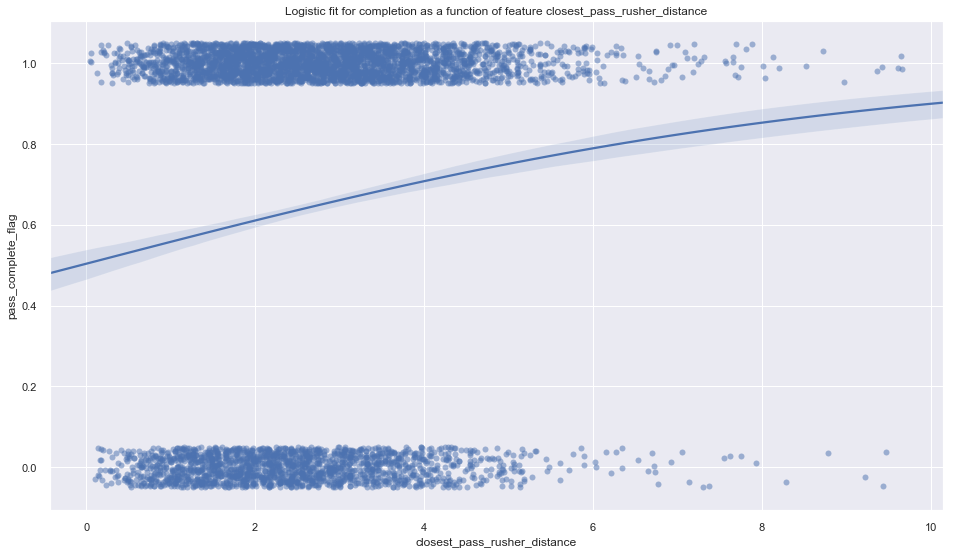

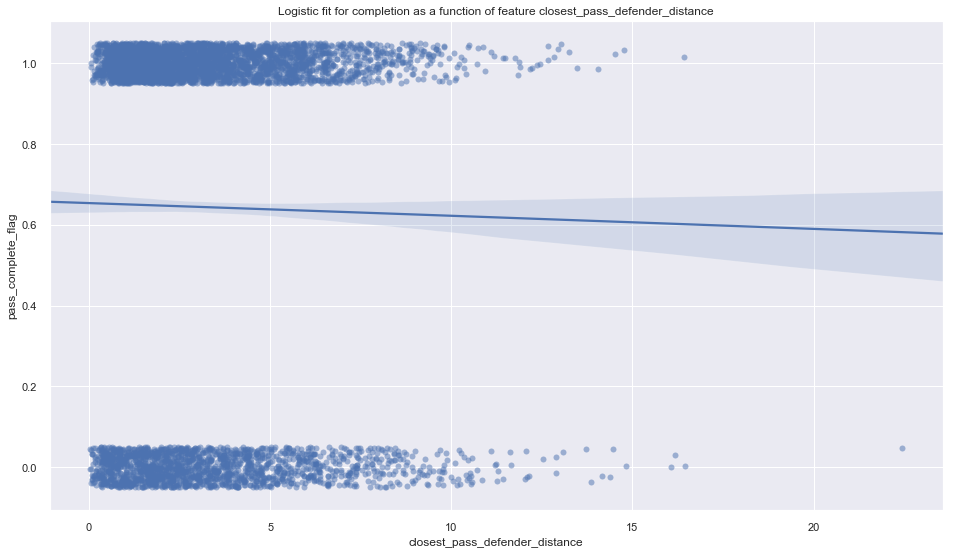

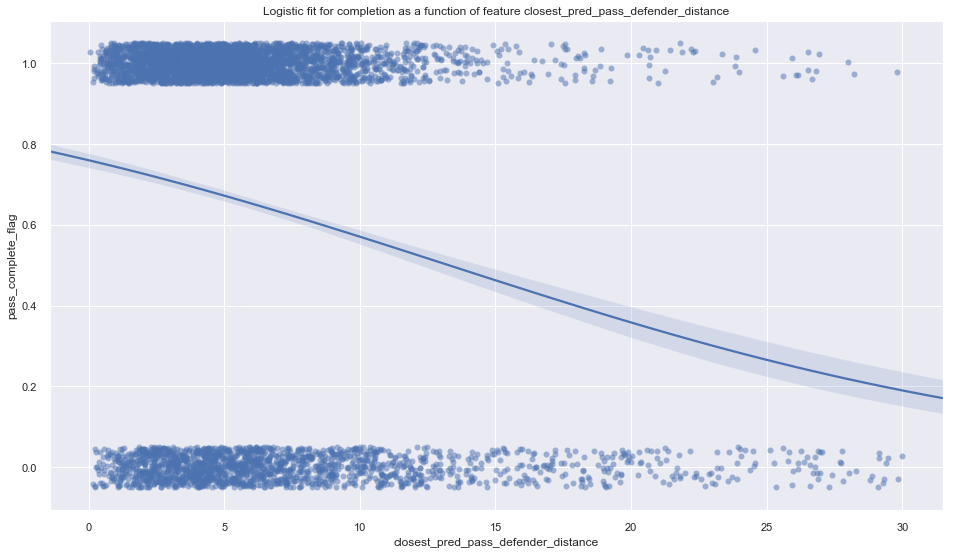

In [16]:
for feature in key_features:    
    sns.regplot(data=df_pred,
                x=feature,
                y='pass_complete_flag',
                logistic=True,
                y_jitter=0.05,
                scatter_kws={'alpha': 0.5})

    plt.title('Logistic fit for completion as a function of feature {:s}'.format(feature))
    plt.show()

## Modeling

### GAMs

In [17]:
def train_and_evaluate_gam(
        df,
        label,
        features,
        classes,
        model=None,
        constraints=None,
        lam=None,
        intercept=True,
        n_splines=10,
        resampler=None,
        test_size=0.2
    ):
    
    # Remove any NAs
    cols = features + [label]
    _df = df[cols].dropna(axis=0, how='any')

    # Handle None inputs
    if constraints is None:
        constraints = [None] * len(features)
        
    if lam is None:
        lam = np.logspace(-3, 3, 11)
    
    # Define X and y arrays
    X = _df[features].values
    y = _df[label].values
    
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1, stratify=y)
        
    # Resample the data
    if resampler is not None:
        X_res, y_res = resampler.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train
                
    # Train the model
    if model is None:
        model = LogisticGAM(n_splines=n_splines, fit_intercept=intercept)
    
    model.gridsearch(X_res,
                     y_res,
                     return_scores=True,
                     constraints=constraints,
                     lam=lam)

    num_terms = [ term for i, term in enumerate(model.terms) if not (term.istensor or term.isintercept) ]
    ten_terms = [ term for i, term in enumerate(model.terms) if term.istensor ]
    
    # Print GAM summary
    model.summary()
    
    # Plot individual features
    # Spline and factor terms
    plt.rcParams['figure.figsize'] = (28, 8)
    fig, axs = plt.subplots(1, len(num_terms))
    ax_idx = 0
        
    for i, term in enumerate(model.terms):
        if term.isintercept or term.istensor:
            continue
            
        XX = model.generate_X_grid(term=i)
        pdep, confi = model.partial_dependence(term=i, X=XX, width=0.9)

        ax = axs[ax_idx]
        ax_idx += 1

        ax.plot(XX[:, term.feature], pdep)
        ax.plot(XX[:, term.feature], confi, c='r', ls='--')
        ax.set_title(term.feature)

    plt.show()
    
    # Tensor terms
    plt.rcParams['figure.figsize'] = (12, 8)
    
    for i, term in enumerate(model.terms):
        if not term.istensor:
            continue

        XX = model.generate_X_grid(term=i, meshgrid=True)
        Z = model.partial_dependence(term=i, X=XX, meshgrid=True)

        ax = plt.axes(projection='3d')
        ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')
        plt.show()

    # Test the model against the held over test set
    y_pred_proba = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    
    # Model metrics
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nPrecision Score: {:3.3f}".format(precision_score(y_test, y_pred)))

    print("\nRecall Score: {:3.3f}".format(recall_score(y_test, y_pred)))

    print("\nF1 Score: {:3.3f}".format(f1_score(y_test, y_pred)))

    print("\nROC AUC Score: {:3.3f}".format(roc_auc_score(y_test, y_pred_proba)))

    print("\nAccuracy: {:3.3f}".format(accuracy_score(y_test, y_pred)))

    print("\nLog Loss: {:3.3f}".format(log_loss(y_test, y_pred_proba)))
    
    return model

100% (42 of 42) |########################| Elapsed Time: 0:00:05 Time:  0:00:05
/Users/ad/Documents/projects/nfl-bdb/venv/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     17.3507
Link Function:                        LogitLink Log Likelihood:                                 -2411.6149
Number of Samples:                         4342 AIC:                                             4857.9313
                                                AICc:                                            4858.0956
                                                UBRE:                                                3.122
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1477
Feature Function                  Lam

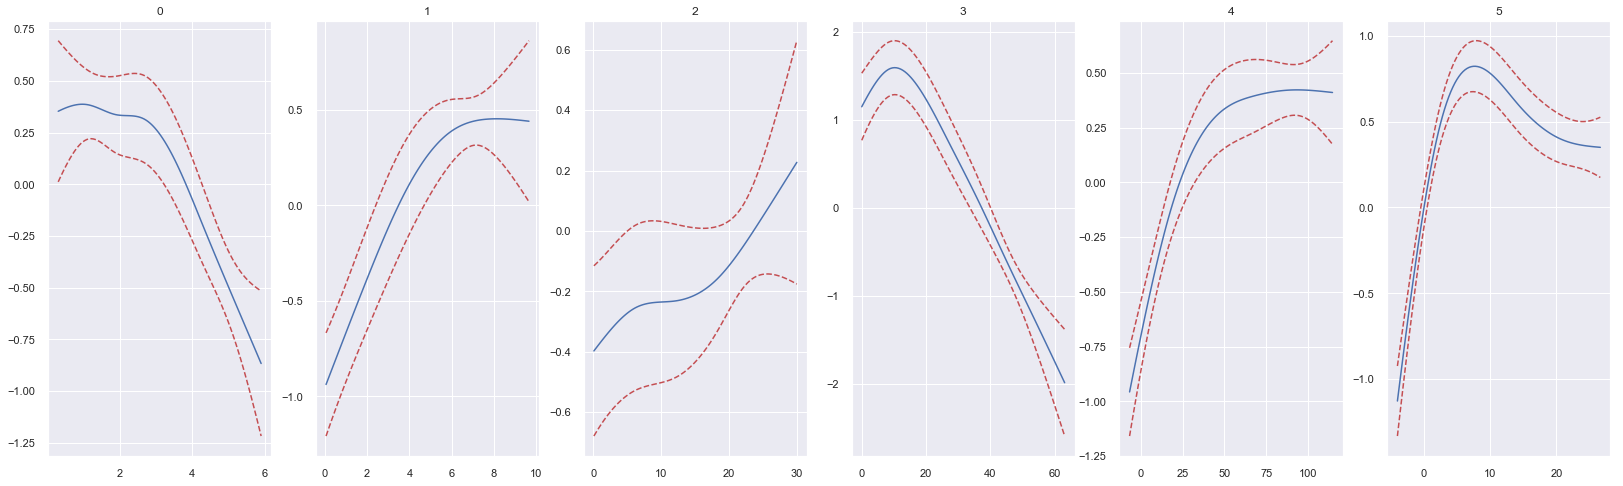


Confusion Matrix:
[[116 158]
 [ 55 438]]

Precision Score: 0.735

Recall Score: 0.888

F1 Score: 0.804

ROC AUC Score: 0.718

Accuracy: 0.722

Log Loss: 0.582


In [18]:
gam_label_1 = 'pass_complete_flag'
gam_classes_1 = ['incomplete', 'complete']
gam_features_1 = [
    'time_to_pass',
    'closest_pass_rusher_distance',
    'closest_pred_pass_defender_distance',
    'throw_distance',
    'arrived_endline_distance',
    'arrived_sideline_distance'
]
gam_constraints_1 = [None, 'monotonic_inc', None, None, None, None, None]
gam_lam_1 = np.logspace(1, 3, 7)
# gam_resampler_1 = SMOTE(random_state=42)
gam_model_1 = LogisticGAM(s(0, n_splines=10) +
                          s(1, n_splines=8, constraints='monotonic_inc') +
                          s(2, n_splines=8, constraints='monotonic_inc') +
                          s(3, n_splines=10) +
                          s(4, n_splines=8) +
                          s(5, n_splines=8))

completion_gam_1 = train_and_evaluate_gam(df=df_pred,
                                          label=gam_label_1,
                                          features=gam_features_1,
                                          classes=gam_classes_1,
                                          model=gam_model_1,
                                          lam=gam_lam_1,
                                          intercept=True,
                                          test_size=0.15)

100% (30 of 30) |########################| Elapsed Time: 0:02:27 Time:  0:02:27


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     41.1394
Link Function:                        LogitLink Log Likelihood:                                 -2359.8456
Number of Samples:                         4342 AIC:                                               4801.97
                                                AICc:                                            4802.8157
                                                UBRE:                                               3.1135
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.166
Feature Function                  Lam

/Users/ad/Documents/projects/nfl-bdb/venv/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



<Figure size 2016x576 with 0 Axes>

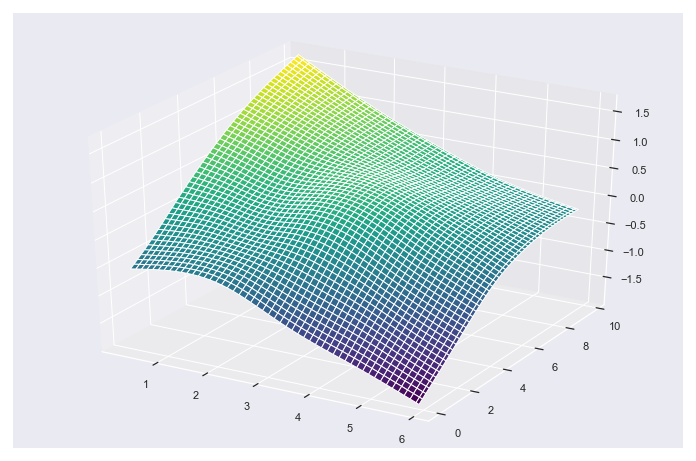

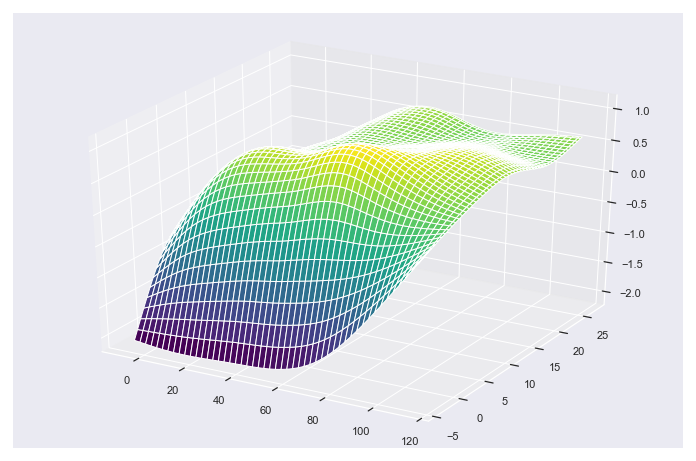

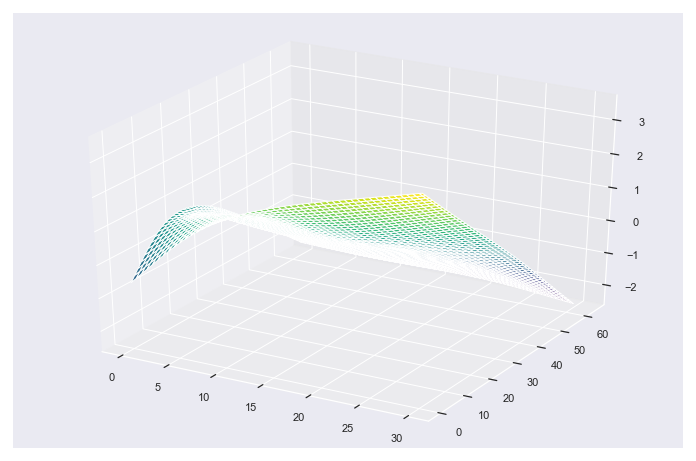


Confusion Matrix:
[[115 159]
 [ 55 438]]

Precision Score: 0.734

Recall Score: 0.888

F1 Score: 0.804

ROC AUC Score: 0.726

Accuracy: 0.721

Log Loss: 0.575


In [19]:
gam_label_2 = 'pass_complete_flag'
gam_classes_2 = ['incomplete', 'complete']
gam_features_2 = [
    'time_to_pass',
    'closest_pass_rusher_distance',
    'arrived_endline_distance',
    'arrived_sideline_distance',
    'closest_pred_pass_defender_distance',
    'throw_distance'
]
gam_lam_2 = np.logspace(1, 3, 5)
# gam_resampler_2 = SMOTE(random_state=42)
gam_model_2 = LogisticGAM(te(0, 1, n_splines=15) +
                          te(2, 3, n_splines=20) +
                          te(4, 5, n_splines=15))

completion_gam_2 = train_and_evaluate_gam(df=df_pred,
                                          label=gam_label_2,
                                          features=gam_features_2,
                                          classes=gam_classes_2,
                                          model=gam_model_2,
                                          lam=gam_lam_2,
                                          intercept=True,
                                          test_size=0.15)

100% (30 of 30) |########################| Elapsed Time: 0:02:18 Time:  0:02:18


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      37.685
Link Function:                        LogitLink Log Likelihood:                                 -2407.8039
Number of Samples:                         4342 AIC:                                             4890.9778
                                                AICc:                                            4891.6915
                                                UBRE:                                               3.1334
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.149
Feature Function                  Lam

/Users/ad/Documents/projects/nfl-bdb/venv/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



<Figure size 2016x576 with 0 Axes>

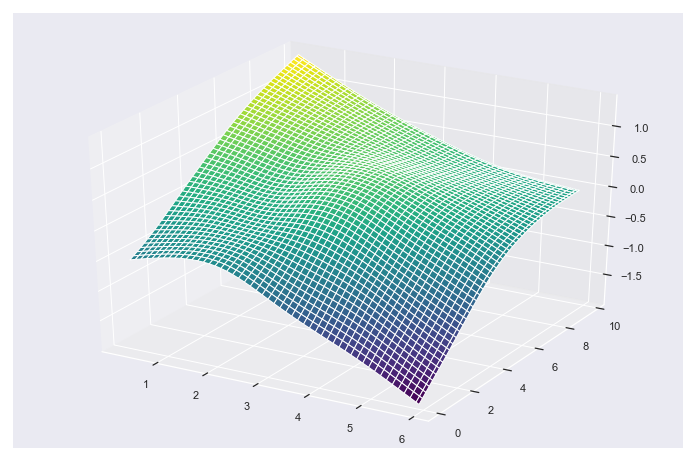

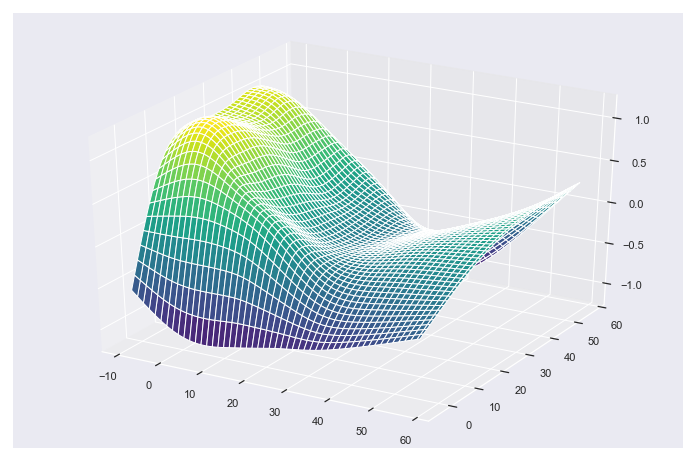

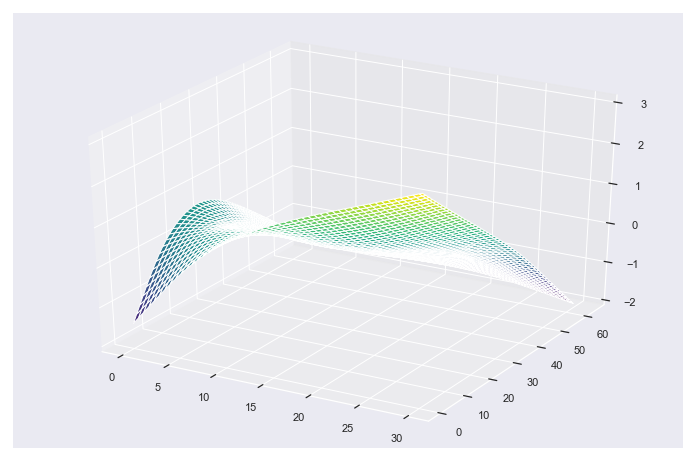


Confusion Matrix:
[[117 157]
 [ 66 427]]

Precision Score: 0.731

Recall Score: 0.866

F1 Score: 0.793

ROC AUC Score: 0.733

Accuracy: 0.709

Log Loss: 0.578


In [45]:
gam_label_3 = 'pass_complete_flag'
gam_classes_3 = ['incomplete', 'complete']
gam_features_3 = [
    'time_to_pass',
    'closest_pass_rusher_distance',
    'arrived_x_rel',
    'arrived_y',
    'closest_pred_pass_defender_distance',
    'throw_distance'
]
gam_lam_3 = np.logspace(1, 3, 5)
# gam_resampler_3 = SMOTE(random_state=42)
gam_model_3 = LogisticGAM(te(0, 1, n_splines=15) +
                          te(2, 3, n_splines=20) +
                          te(4, 5, n_splines=15))

completion_gam_3 = train_and_evaluate_gam(df=df_pred,
                                          label=gam_label_3,
                                          features=gam_features_3,
                                          classes=gam_classes_3,
                                          model=gam_model_3,
                                          lam=gam_lam_3,
                                          intercept=True,
                                          test_size=0.15)

### XGBoost

In [21]:
def train_and_evaluate_classifier(
        df,
        label,
        features,
        classes,
        classifier,
        xgb_scale=None,
        scaler=None,
        resampler=None,
        test_size=0.20
    ):
    
    # Remove any NAs
    cols = features + [label]
    _df = df[cols].dropna(axis=0, how='any')
    
    y = _df[label]
    X = _df[features]
    
    # Preprocessing
    if scaler is not None:
        try:
            X = scaler.fit_transform(X)
        except:
            print("Error:", sys.exc_info()[0])
            raise
        
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42)
    
    # Resample the data
    if resampler is not None:
        X_res, y_res = resampler.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train

    # Train the model
    classifier.fit(X_res, y_res)

    # Classifier description
    classifier_name = type(classifier).__name__
    if classifier_name in ['LogisticRegression']:
        print('COEFFICIENTS FOR {:s} CLASSIFIER'.format(classifier_name))
        
        intercept = classifier.intercept_
        if type(intercept) == np.ndarray:
            intercept = intercept[0]
        
        print("{:30}[{:5.3f}]".format('Intercept:', intercept))

        for feature, weight in list(zip(features, classifier.coef_[0])):
            print("{:30}[{:5.4f}]".format(feature + ":", weight))
        print('\n')
        
    if classifier_name in ['XGBClassifier']:
        plot_importance(classifier)
        plt.show()
        
    # Class prediction error plot
    cpe_plot = ClassPredictionError(classifier, classes=classes)
    cpe_plot.fit(X_train, y_train)
    cpe_plot.score(X_test, y_test)
    cpe_plot.poof()
    
    # Classification report
    cr_plot = ClassificationReport(classifier, classes=classes, support=True)
    cr_plot.fit(X_train, y_train)
    cr_plot.score(X_test, y_test)
    cr_plot.poof()
    
    # ROC/AUC plot
    rocauc_plot = ROCAUC(classifier, classes=classes)
    rocauc_plot.fit(X_train, y_train)
    rocauc_plot.score(X_test, y_test)
    rocauc_plot.poof()
    
    # Precision recall plot
    pr_plot = PrecisionRecallCurve(classifier)
    pr_plot.fit(X_train, y_train)
    pr_plot.score(X_test, y_test)
    pr_plot.poof()
        
    # Discrimination Threshold
    dt_plot = DiscriminationThreshold(classifier)
    dt_plot.fit(X_train, y_train)
    dt_plot.poof()
        
    return classifier

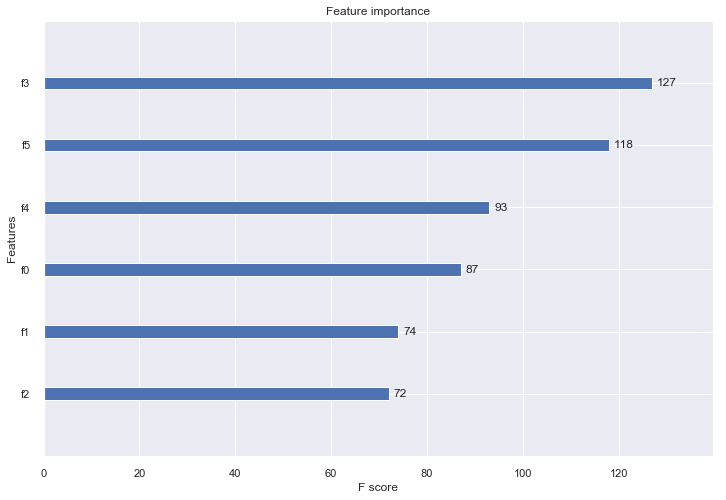

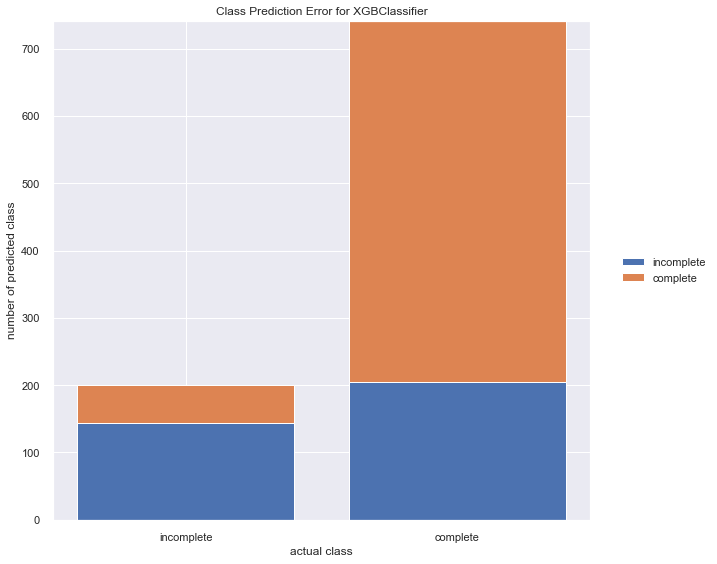

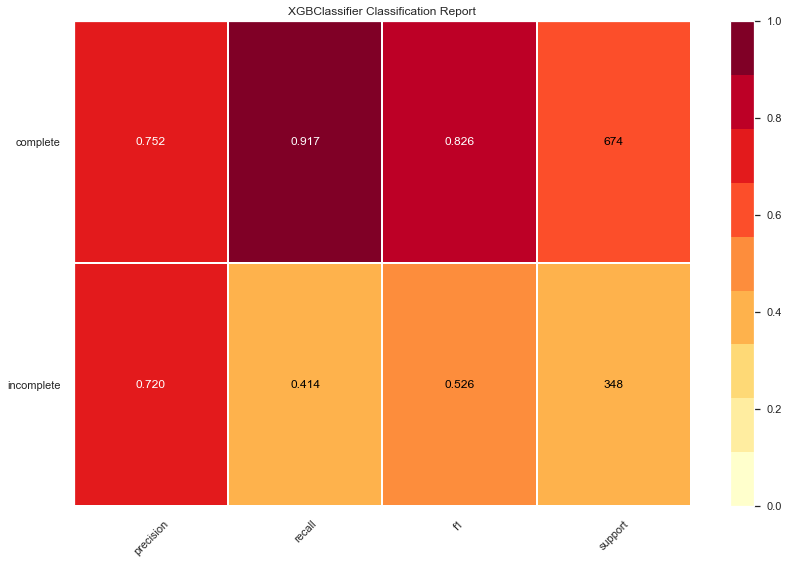

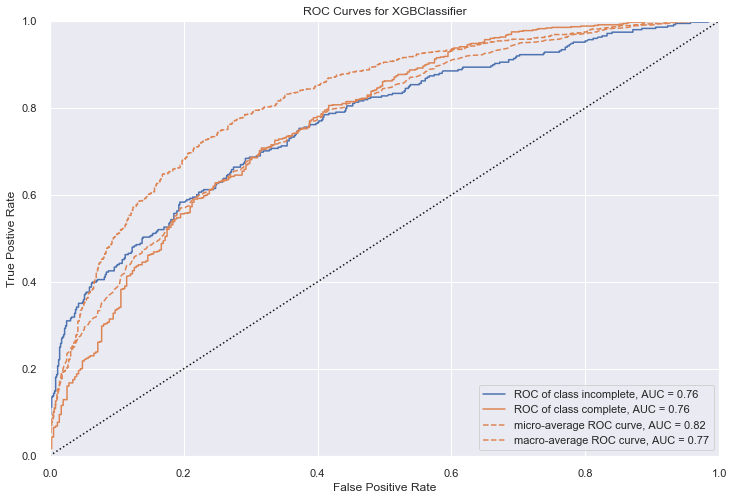

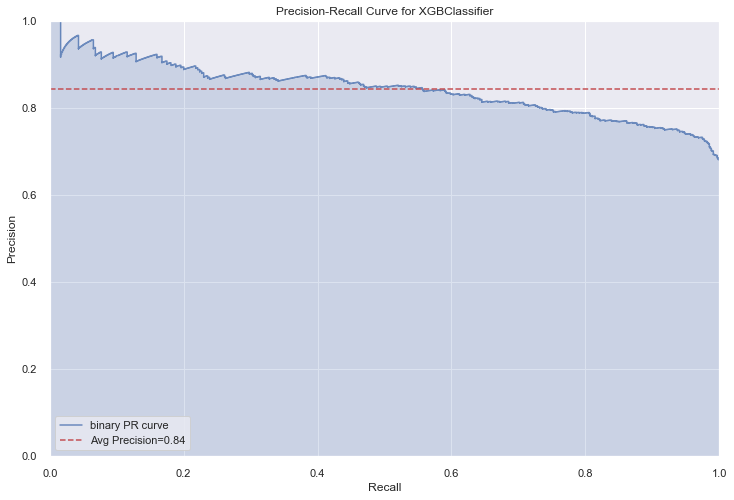

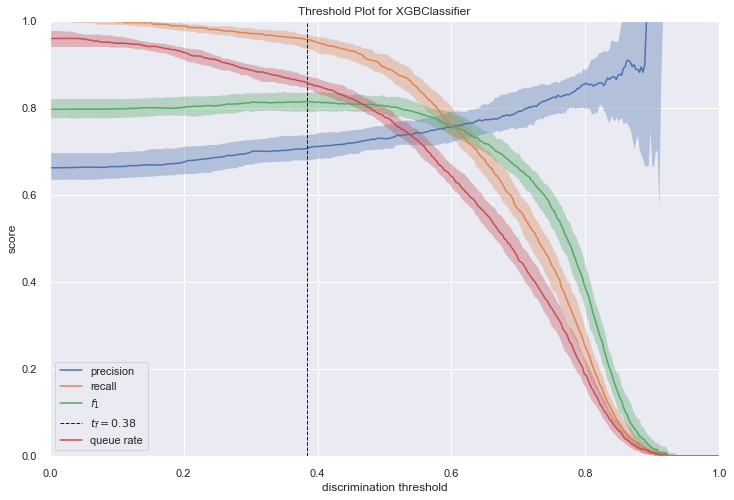

In [58]:
xgb_label_1 = 'pass_complete_flag'
xgb_classes_1 = ['incomplete', 'complete']
xgb_features_1 = [
    'time_to_pass',
    'closest_pass_rusher_distance',
    'arrived_x_rel',
    'arrived_sideline_distance',
    'closest_pred_pass_defender_distance',
    'throw_distance'
]

xgb_model_1 = XGBClassifier(scale_pos_weight=0.9)
xgb_scaler_1 = MaxAbsScaler()
# xgb_resampler_1 = RandomUnderSampler(random_state=42)

completion_xgb_1 = train_and_evaluate_classifier(df=df_pred,
                                                 label=xgb_label_1,
                                                 features=xgb_features_1,
                                                 classes=xgb_classes_1,
                                                 classifier=xgb_model_1,
                                                 scaler=xgb_scaler_1,
                                                 test_size=0.20)

## Model application

In [52]:
def apply_model(
        df,
        model,
        features,
        label,
        agg_column,
        count_column,
        scaler=None
    ):
    
    # Get useful features
    cols = features + [label, agg_column, count_column]
    output = df[cols].copy()
    output = output.dropna(axis=0, how='any')
        
    X = output[features]
    if scaler is not None:
        X = scaler.transform(X)
    
    pred_col = '{:s}_pred'.format(label)
    prob_col = '{:s}_prob'.format(label)
    
    # Generate predictions
    probs = model.predict_proba(X)
    if probs.ndim > 1:
        probs = np.asarray([ p[1] for p in probs ])
    
    output[pred_col] = model.predict(X)
    output[prob_col] = probs
        
    # Summarize results
    output_agg = output.groupby(agg_column).agg({
        label: 'mean',
        prob_col: 'mean',
        count_column: 'count'
    })
    
    output_agg = output_agg.rename(columns={
        count_column: 'count'
    })
    
    delta_col = '{:s}_delta'.format(label)
    output_agg[delta_col] = output_agg[label] - output_agg[prob_col]
    
    return output, output_agg

In [60]:
gam_qb, gam_qb_agg = apply_model(df=df_base,
                                 model=completion_gam_3,
                                 features=gam_features_3,
                                 label=gam_label_3,
                                 agg_column='qb_name',
                                 count_column='play_id')

gam_qb_agg = gam_qb_agg[gam_qb_agg['count'] > 50]
gam_qb_agg = gam_qb_agg.rename(columns={
    'pass_complete_flag': 'completion_pct',
    'pass_complete_flag_prob': 'exp_completion_pct',
    'count': 'attempts',
    'pass_complete_flag_delta': 'completion_pct_delta'
})

gam_qb_agg.sort_values(by='exp_completion_pct', ascending=False).head(50)

completion_pct  exp_completion_pct  attempts  \
qb_name                                                            
Drew Brees                   0.677               0.661       158   
Mike Glennon                 0.631               0.660       122   
Derek Carr                   0.667               0.659       123   
Philip Rivers                0.617               0.659       209   
Eli Manning                  0.652               0.657       198   
Joe Flacco                   0.617               0.656       167   
Jay Cutler                   0.583               0.654       151   
Josh McCown                  0.720               0.653       157   
Andy Dalton                  0.630               0.645       138   
Tyrod Taylor                 0.632               0.644       125   
Aaron Rodgers                0.648               0.640       179   
Matt Ryan                    0.652               0.635       155   
Trevor Siemian               0.591               0.631       164   
Matthew Stafford             0.590               0.629       195   
Brian Hoyer                  0.557               0.628       185   
Carson Palmer                0.594               0.624       224   
Kirk Cousins                 0.660               0.619       150   
Alex Smith                   0.698               0.619       169   
Blake Bortles                0.550               0.617       149   
Dak Prescott                 0.620               0.617       163   
Tom Brady                    0.643               0.616       185   
Ben Roethlisberger           0.616               0.614       190   
Cam Newton                   0.634               0.611       186   
Marcus Mariota               0.585               0.605       118   
Kevin Hogan                  0.600               0.605        65   
Carson Wentz                 0.614               0.598       184   
Jameis Winston               0.579               0.597       145   
Jared Goff                   0.590               0.597       173   
Case Keenum                  0.628               0.596       145   
DeShone Kizer                0.479               0.593       144   
Jacoby Brissett              0.582               0.589       153   
Russell Wilson               0.614               0.568       158   
Deshaun Watson               0.598               0.564       122   

                    completion_pct_delta  
qb_name                                   
Drew Brees                         0.017  
Mike Glennon                      -0.029  
Derek Carr                         0.008  
Philip Rivers                     -0.041  
Eli Manning                       -0.005  
Joe Flacco                        -0.039  
Jay Cutler                        -0.071  
Josh McCown                        0.067  
Andy Dalton                       -0.014  
Tyrod Taylor                      -0.012  
Aaron Rodgers                      0.008  
Matt Ryan                          0.016  
Trevor Siemian                    -0.039  
Matthew Stafford                  -0.039  
Brian Hoyer                       -0.071  
Carson Palmer                     -0.030  
Kirk Cousins                       0.041  
Alex Smith                         0.080  
Blake Bortles                     -0.067  
Dak Prescott                       0.003  
Tom Brady                          0.028  
Ben Roethlisberger                 0.002  
Cam Newton                         0.023  
Marcus Mariota                    -0.021  
Kevin Hogan                       -0.005  
Carson Wentz                       0.016  
Jameis Winston                    -0.018  
Jared Goff                        -0.007  
Case Keenum                        0.031  
DeShone Kizer                     -0.114  
Jacoby Brissett                   -0.008  
Russell Wilson                     0.046  
Deshaun Watson                     0.034

In [25]:
gam_wr, gam_wr_agg = apply_model(df=df_pred,
                                 model=completion_gam_3,
                                 features=gam_features_3,
                                 label=gam_label_3,
                                 agg_column='receiver_name',
                                 count_column='play_id')

gam_wr_agg = gam_wr_agg[gam_wr_agg['count'] > 15]
gam_wr_agg = gam_wr_agg.rename(columns={
    'pass_complete_flag': 'completion_pct',
    'pass_complete_flag_prob': 'exp_completion_pct',
    'count': 'targets',
    'pass_complete_flag_delta': 'completion_pct_delta'
})


gam_wr_agg.sort_values(by='exp_completion_pct', ascending=True).head(50)

completion_pct  exp_completion_pct  targets  \
receiver_name                                                   
Paul Richardson            0.500               0.441       24   
Tyler Higbee               0.417               0.499       24   
Marvin Jones               0.500               0.499       26   
Stefon Diggs               0.640               0.504       25   
John Brown                 0.500               0.505       24   
Torrey Smith               0.579               0.509       19   
Donte Moncrief             0.667               0.513       18   
Jaron Brown                0.542               0.521       24   
DeAndre Hopkins            0.533               0.522       45   
Robby Anderson             0.444               0.526       27   
DeSean Jackson             0.542               0.526       24   
Zay Jones                  0.278               0.531       18   
Marquise Goodwin           0.464               0.536       28   
DeVante Parker             0.619               0.537       21   
T.Y. Hilton                0.625               0.538       32   
Kenny Britt                0.263               0.546       19   
Devin Funchess             0.649               0.547       37   
Ryan Grant                 0.650               0.548       20   
Tyler Lockett              0.684               0.549       19   
Aldrick Robinson           0.348               0.551       23   
Ed Dickson                 0.565               0.556       23   
Dez Bryant                 0.459               0.558       37   
J.J. Nelson                0.588               0.560       17   
Travis Benjamin            0.611               0.562       18   
Adam Thielen               0.735               0.566       49   
Kenny Stills               0.550               0.568       20   
Mike Wallace               0.565               0.571       23   
Rishard Matthews           0.583               0.573       36   
Mike Evans                 0.514               0.574       35   
Marqise Lee                0.536               0.577       28   
Brandin Cooks              0.571               0.578       28   
Allen Hurns                0.720               0.578       25   
Pierre Garcon              0.553               0.583       47   
Kamar Aiken                0.333               0.584       27   
Michael Crabtree           0.700               0.584       30   
Demaryius Thomas           0.676               0.588       37   
Robert Woods               0.621               0.588       29   
Ted Ginn                   0.706               0.592       17   
Odell Beckham              0.594               0.596       32   
Kelvin Benjamin            0.688               0.597       32   
Jordy Nelson               0.677               0.599       31   
Hunter Henry               0.636               0.601       22   
Terrelle Pryor             0.636               0.602       22   
Cole Beasley               0.583               0.602       24   
Antonio Brown              0.706               0.603       51   
Taylor Gabriel             0.682               0.603       22   
Eric Decker                0.690               0.603       29   
Jimmy Graham               0.645               0.604       31   
Ricardo Louis              0.615               0.605       26   
Alshon Jeffery             0.621               0.605       29   

                  completion_pct_delta  
receiver_name                           
Paul Richardson                  0.059  
Tyler Higbee                    -0.082  
Marvin Jones                     0.001  
Stefon Diggs                     0.136  
John Brown                      -0.005  
Torrey Smith                     0.070  
Donte Moncrief                   0.153  
Jaron Brown                      0.021  
DeAndre Hopkins                  0.011  
Robby Anderson                  -0.082  
DeSean Jackson                   0.015  
Zay Jones                       -0.253  
Marquise Goodwin                -0.071  
DeVante Parker        

In [59]:
xgb_qb, xgb_qb_agg = apply_model(df=df_pred,
                                 model=completion_xgb_1,
                                 features=xgb_features_1,
                                 label=xgb_label_1,
                                 agg_column='qb_name',
                                 count_column='play_id',
                                 scaler=xgb_scaler_1)

xgb_qb_agg = xgb_qb_agg[xgb_qb_agg['count'] > 50]
xgb_qb_agg = xgb_qb_agg.rename(columns={
    'pass_complete_flag': 'completion_pct',
    'pass_complete_flag_prob': 'exp_completion_pct',
    'count': 'attempts',
    'pass_complete_flag_delta': 'completion_pct_delta'
})

xgb_qb_agg.sort_values(by='exp_completion_pct', ascending=False).head(50)

completion_pct  exp_completion_pct  attempts  \
qb_name                                                            
Aaron Rodgers                0.690               0.663       158   
Josh McCown                  0.753               0.663       146   
Philip Rivers                0.633               0.659       199   
Drew Brees                   0.680               0.656       153   
Mike Glennon                 0.647               0.655       119   
Joe Flacco                   0.652               0.655       155   
Eli Manning                  0.668               0.646       184   
Derek Carr                   0.692               0.640       117   
Andy Dalton                  0.686               0.640       121   
Jay Cutler                   0.592               0.637       142   
Ben Roethlisberger           0.669               0.632       163   
Matthew Stafford             0.628               0.632       180   
Matt Ryan                    0.683               0.631       145   
Tyrod Taylor                 0.652               0.630       115   
Carson Wentz                 0.671               0.626       158   
Alex Smith                   0.718               0.626       156   
Tom Brady                    0.661               0.624       174   
Kirk Cousins                 0.703               0.619       138   
Carson Palmer                0.624               0.616       205   
Brian Hoyer                  0.559               0.614       177   
Trevor Siemian               0.632               0.613       144   
Jacoby Brissett              0.623               0.612       138   
Cam Newton                   0.657               0.612       172   
Dak Prescott                 0.619               0.605       155   
Case Keenum                  0.669               0.604       133   
Blake Bortles                0.577               0.604       137   
Deshaun Watson               0.615               0.602       104   
Marcus Mariota               0.615               0.602       109   
Kevin Hogan                  0.672               0.598        58   
Jared Goff                   0.611               0.596       162   
DeShone Kizer                0.507               0.589       134   
Jameis Winston               0.596               0.585       136   
Russell Wilson               0.647               0.560       150   

                    completion_pct_delta  
qb_name                                   
Aaron Rodgers                      0.027  
Josh McCown                        0.090  
Philip Rivers                     -0.026  
Drew Brees                         0.024  
Mike Glennon                      -0.008  
Joe Flacco                        -0.003  
Eli Manning                        0.022  
Derek Carr                         0.052  
Andy Dalton                        0.046  
Jay Cutler                        -0.046  
Ben Roethlisberger                 0.036  
Matthew Stafford                  -0.004  
Matt Ryan                          0.051  
Tyrod Taylor                       0.023  
Carson Wentz                       0.044  
Alex Smith                         0.092  
Tom Brady                          0.037  
Kirk Cousins                       0.084  
Carson Palmer                      0.008  
Brian Hoyer                       -0.055  
Trevor Siemian                     0.019  
Jacoby Brissett                    0.011  
Cam Newton                         0.045  
Dak Prescott                       0.014  
Case Keenum                        0.065  
Blake Bortles                     -0.027  
Deshaun Watson                     0.013  
Marcus Mariota                     0.013  
Kevin Hogan                        0.074  
Jared Goff                         0.015  
DeShone Kizer                     -0.081  
Jameis Winston                     0.010  
Russell Wilson                     0.087

In [61]:
model_qb_agg = pd.merge(gam_qb_agg,
                        xgb_qb_agg,
                        on='qb_name',
                        suffixes=['_gam', '_xgb'])

In [62]:
model_qb_agg.head()

completion_pct_gam  exp_completion_pct_gam  attempts_gam  \
qb_name                                                                        
Aaron Rodgers                    0.648                   0.640           179   
Alex Smith                       0.698                   0.619           169   
Andy Dalton                      0.630                   0.645           138   
Ben Roethlisberger               0.616                   0.614           190   
Blake Bortles                    0.550                   0.617           149   

                    completion_pct_delta_gam  completion_pct_xgb  \
qb_name                                                            
Aaron Rodgers                          0.008               0.690   
Alex Smith                             0.080               0.718   
Andy Dalton                           -0.014               0.686   
Ben Roethlisberger                     0.002               0.669   
Blake Bortles                         -0.067               0.577   

                    exp_completion_pct_xgb  attempts_xgb  \
qb_name                                                    
Aaron Rodgers                        0.663           158   
Alex Smith                           0.626           156   
Andy Dalton                          0.640           121   
Ben Roethlisberger                   0.632           163   
Blake Bortles                        0.604           137   

                    completion_pct_delta_xgb  
qb_name                                       
Aaron Rodgers                          0.027  
Alex Smith                             0.092  
Andy Dalton                            0.046  
Ben Roethlisberger                     0.036  
Blake Bortles                         -0.027

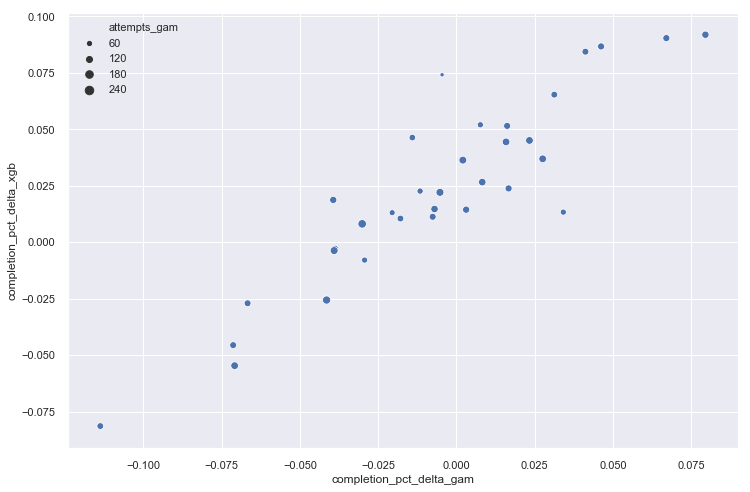

In [66]:
sns.scatterplot(data=model_qb_agg,
                x='completion_pct_delta_gam',
                y='completion_pct_delta_xgb',
                size='attempts_gam')